In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time


from sklearn.model_selection import train_test_split

import gc

seed=15

In [2]:
# aux
import sys

variable_sizes = {name: sys.getsizeof(obj) for name, obj in globals().items()}

sorted_variable_sizes = sorted(variable_sizes.items(), key=lambda x: x[1], reverse=True)

for name, size in sorted_variable_sizes:
    print(f"{name}: {size} bytes")


_i2: 312 bytes
_i: 238 bytes
_i1: 238 bytes
_oh: 232 bytes
Out: 232 bytes
train_test_split: 136 bytes
__doc__: 113 bytes
_ih: 96 bytes
In: 96 bytes
__builtin__: 72 bytes
__builtins__: 72 bytes
np: 72 bytes
pd: 72 bytes
plt: 72 bytes
sns: 72 bytes
time: 72 bytes
gc: 72 bytes
sys: 72 bytes
_dh: 64 bytes
get_ipython: 64 bytes
__name__: 57 bytes
_: 51 bytes
__: 51 bytes
___: 51 bytes
_ii: 51 bytes
_iii: 51 bytes
exit: 48 bytes
quit: 48 bytes
seed: 28 bytes
__package__: 16 bytes
__loader__: 16 bytes
__spec__: 16 bytes


In [3]:
#del df_client

In [4]:
gc.collect()

45

In [5]:
min_rates_movies = 100
min_rates_users = 100

# Lectura de datos

In [6]:
%%time
df1 = pd.read_parquet("../data/combined_data_con_id.gzip")

Wall time: 43.6 s


In [7]:
df1 = df1.rename(columns={"id_client": "user_id", "id_movie": "movie_id", 'rate':'rating','rate_day':'rate_day'})

In [8]:
df1.head()

,movie_id,user_id,rating,rate_day
0,1,822109,5,2005-05-13
1,1,885013,4,2005-10-19
2,1,30878,4,2005-12-26
3,1,823519,3,2004-05-03
4,1,893988,3,2005-11-17


In [9]:
%%time
df_movie = df1.groupby('movie_id')['user_id'].count()
df_movie.head()

Wall time: 3.87 s


movie_id
1     546
2     145
3    2012
4     142
5    1140
Name: user_id, dtype: int64

In [10]:
df_movie.shape

(17770,)

In [11]:
for i in range(5):
    df_shape = df_movie[df_movie>=10**i].shape[0]
    print(f"{10**i}:\t{df_shape}\t{df_shape/df_movie.shape[0]:.2%}")

1:	17770	100.00%
10:	17768	99.99%
100:	16795	94.51%
1000:	7127	40.11%
10000:	2042	11.49%


In [12]:
df_client = df1.groupby('user_id')['movie_id'].count()
df_client.head()

user_id
6     626
7     881
8      98
10    260
25     27
Name: movie_id, dtype: int64

In [13]:
df_client.shape

(480189,)

In [14]:
result = 1
b=10
i=0
while result > 0 and i<100:
    result = df_client[df_client>=b**i].shape[0]
    print(f"{i:3d} ({b**i:6d}): {result:6d} ({result/df_client.shape[0]:6.2%})")
    i+=1

  0 (     1): 480189 (100.00%)
  1 (    10): 463770 (96.58%)
  2 (   100): 236117 (49.17%)
  3 (  1000):  13141 ( 2.74%)
  4 ( 10000):      5 ( 0.00%)
  5 (100000):      0 ( 0.00%)


In [15]:
%%time

exp_mv = 4
exp_us = 3

# Inicializar las potencias de 10
movie_range = [10**i for i in range(0, exp_mv+1)]  # Desde 10 hasta 10,000
user_range = [10**j for j in range(0, exp_us+1)]   # Desde 10 hasta 10,000


# Inicializar una lista para almacenar los resultados
mv_count, min_mv_count, usr_count, min_usr_count, shape_count, filtered_dfs = [],[],[],[],[],[]
mv_pct, usr_pct = [],[]
t0=time()
# Filtrar df1 por conteos de películas y usuarios
for movie_count in movie_range:
    filtered_movies = df_movie[df_movie >= movie_count].index.tolist()
    
    for user_count in user_range:
        min_mv_count.append(movie_count)
        min_usr_count.append(user_count)
        
        # Filtrar películas
        mv_count.append(len(filtered_movies))
        
        # Filtrar usuarios
        filtered_users = df_client[df_client >= user_count].index.tolist()
        usr_count.append(len(filtered_users))
        
        # Aplicar los filtros
        filtered_df = df1[df1['movie_id'].isin(filtered_movies) & df1['user_id'].isin(filtered_users)]
        shape_count.append(filtered_df.shape[0])
        
        # Almacenar el resultado y las condiciones
        #filtered_dfs.append(filtered_df.copy())
        t1=time()
        print(f"Iteration movie count {movie_count:6d}, user count {user_count:6d}: Time elapsed {(t1-t0)/60} mins")

n_usrs = df_client.shape[0]
n_mvs = df_movie.shape[0]
max_shape = df1.shape[0]

usr_pct = [c*100/n_usrs for c in usr_count]
mv_pct = [c*100/n_mvs for c in mv_count]
ratio_lst = [shape_count[i]/(mv_count[i]*usr_count[i]) for i in range(len(usr_count))]
pct_full = [s*100/max_shape for s in shape_count]
    
df_conteos = pd.DataFrame({'Movie_min_ratings':min_mv_count
                           ,'User_min_ratings':min_usr_count
                           ,'Movie_count':mv_count
                           ,'Movie_pct':mv_pct
                           ,'User_count':usr_count
                           ,'User_pct':usr_pct
                           ,'Shape':shape_count
                           ,'Ratio':ratio_lst
                           ,'Shape_pct':pct_full
                          })
df_conteos.to_csv('../data/df_conteos_exp10.csv',index=False)
df_conteos

Iteration movie count      1, user count      1: Time elapsed 0.6688070654869079 mins
Iteration movie count      1, user count     10: Time elapsed 1.7078291376431782 mins
Iteration movie count      1, user count    100: Time elapsed 2.6601440350214642 mins
Iteration movie count      1, user count   1000: Time elapsed 3.011207624276479 mins
Iteration movie count     10, user count      1: Time elapsed 3.6728853742281595 mins
Iteration movie count     10, user count     10: Time elapsed 4.666668200492859 mins
Iteration movie count     10, user count    100: Time elapsed 5.502982389926911 mins
Iteration movie count     10, user count   1000: Time elapsed 5.851259895165762 mins
Iteration movie count    100, user count      1: Time elapsed 6.360357729593913 mins


KeyboardInterrupt: 

In [28]:
df_conteos2=pd.read_csv('../data/df_conteos_exp10.csv')
#df_conteos2['Shape_trainval'] = df_conteos2['Shape']*0.7
df_conteos2

,Movie_min_ratings,User_min_ratings,Movie_count,Movie_pct,User_count,User_pct,Shape,Ratio,Shape_pct
0,1,1,17770,100.000000,480189,100.000000,100480506,0.011776,100.000000
1,1,10,17770,100.000000,463770,96.580721,100396383,0.012182,99.916279
2,1,100,17770,100.000000,236117,49.171680,89973533,0.021444,89.543272
3,1,1000,17770,100.000000,13141,2.736631,18786255,0.080450,18.696418
4,10,1,17768,99.988745,480189,100.000000,100480498,0.011777,99.999992
5,10,10,17768,99.988745,463770,96.580721,100396375,0.012184,99.916271
6,10,100,17768,99.988745,236117,49.171680,89973526,0.021446,89.543265
7,10,1000,17768,99.988745,13141,2.736631,18786252,0.080459,18.696415
8,100,1,16795,94.513225,480189,100.000000,100400917,0.012449,99.920792
9,100,10,16795,94.513225,463770,96.580721,100317000,0.012879,99.837276


In [29]:
df_conteos2[(df_conteos2['Movie_min_ratings'] >= min_rates_movies) & (df_conteos2['User_min_ratings'] >= min_rates_users)]

,Movie_min_ratings,User_min_ratings,Movie_count,Movie_pct,User_count,User_pct,Shape,Ratio,Shape_pct
10,100,100,16795,94.513225,236117,49.171680,89902830,0.022671,89.472907
11,100,1000,16795,94.513225,13141,2.736631,18757425,0.084989,18.667725
14,1000,100,7127,40.106922,236117,49.171680,86963967,0.051678,86.548098
15,1000,1000,7127,40.106922,13141,2.736631,17703382,0.189026,17.618723
18,10000,100,2042,11.491277,236117,49.171680,71011841,0.147281,70.672257
19,10000,1000,2042,11.491277,13141,2.736631,12168105,0.453460,12.109916


# Elección de películas y usuarios
Como el dataset es demasiado grande y el modelo + mi ordenador no puede con él, vamos a tomar 10.000 películas y 50.000 usuarios de manera aleatoria

In [18]:
nmovies_filt = 10000
nusers_filt = 100000

In [19]:
filtered_movies = df_movie[df_movie >= min_rates_movies].index.tolist()
filtered_users = df_client[df_client >= min_rates_users].index.tolist()

filtered_df = df1[df1['movie_id'].isin(filtered_movies) & df1['user_id'].isin(filtered_users)]
filtered_df.shape

(89902830, 4)

In [20]:
filtered_df.head()

,movie_id,user_id,rating,rate_day
0,1,822109,5,2005-05-13
1,1,885013,4,2005-10-19
2,1,30878,4,2005-12-26
3,1,823519,3,2004-05-03
4,1,893988,3,2005-11-17


In [21]:
len(filtered_movies)

16795

In [22]:
len(filtered_users)

236117

In [23]:
selected_movie_ids = np.random.choice(filtered_df['movie_id'].unique(), nmovies_filt, replace=False)
selected_user_ids = np.random.choice(filtered_df['user_id'].unique(), nusers_filt, replace=False)

filtered_df_2 = filtered_df[filtered_df['movie_id'].isin(selected_movie_ids) & filtered_df['user_id'].isin(selected_user_ids)]
filtered_df_2

,movie_id,user_id,rating,rate_day
546,2,2059652,4,2005-09-05
550,2,998862,4,2004-11-13
555,2,988104,3,2005-05-23
558,2,1793899,5,2005-06-04
559,2,1340535,5,2004-12-12
...,...,...,...,...
100480491,17770,925414,4,2005-02-08
100480496,17770,834323,2,2005-10-04
100480497,17770,516110,5,2004-08-26
100480501,17770,1790158,4,2005-11-01


In [24]:
filtered_df_2['movie_id'].nunique()

10000

In [25]:
filtered_df_2['user_id'].nunique()

100000

In [26]:
#df_movie_filt = filtered_df_2.groupby('movie_id')['user_id'].count()
df_movie_filt.nsmallest(10)

NameError: name 'df_movie_filt' is not defined

In [ ]:
plt.figure(figsize=(12, 8))
sns.histplot(df_movie_filt,log_scale=True,bins=50)
plt.title('Histograma ID Película', fontsize=16)
# Configurar título y etiquetas
plt.xlabel('Puntuaciones recibidas', fontsize=14)
plt.ylabel('Conteo', fontsize=14)

In [ ]:
#df_user_filt = filtered_df_2.groupby('user_id')['movie_id'].count()
df_user_filt.nsmallest(10)

In [ ]:
plt.figure(figsize=(12, 8))
sns.histplot(df_user_filt,log_scale=True,bins=50)
plt.title('Histograma ID Cliente', fontsize=16)
# Configurar título y etiquetas
plt.xlabel('Películas puntuadas', fontsize=14)
plt.ylabel('Conteo', fontsize=14)

In [27]:
%%time
iteration_lst,mv_min_ratings_lst,user_min_ratings_lst,df_filt_shape_lst,nmovies_shape,nusers_shape = [],[],[],[],[],[]

mv_min_ratings = 100
usr_min_ratings = 100

mv_min_rating_actual, usr_min_rating_actual = 0, 0

df_filt = filtered_df_2.copy()
df_filt = df_filt.drop('rate_day',axis=1)


df_movie = df_filt.groupby('movie_id')['user_id'].count()
df_user = df_filt.groupby('user_id')['movie_id'].count()

filtered_movies = df_movie[df_movie >= mv_min_ratings].index.tolist()
filtered_users = df_user[df_user >= usr_min_ratings].index.tolist()

iteration = 0
print('BUCLE INTERACIONES')
t_tot = time()
while not (mv_min_rating_actual >= mv_min_ratings and usr_min_rating_actual >= usr_min_ratings) and iteration < 100:
    
    t0=time()
    
    df_filt = df_filt[df_filt['movie_id'].isin(filtered_movies) & df_filt['user_id'].isin(filtered_users)]
    
    df_movie = df_filt.groupby('movie_id')['user_id'].count()
    df_user = df_filt.groupby('user_id')['movie_id'].count()

    filtered_movies = df_movie[df_movie >= mv_min_ratings].index.tolist()
    filtered_users = df_user[df_user >= usr_min_ratings].index.tolist()

    mv_min_rating_actual = df_movie.min()
    usr_min_rating_actual = df_user.min()
    
    
    iteration_lst.append(iteration)
    mv_min_ratings_lst.append(mv_min_rating_actual)
    user_min_ratings_lst.append(usr_min_rating_actual)
    df_filt_shape_lst.append(df_filt.shape[0])
    nmovies_shape.append(df_movie.shape[0])
    nusers_shape.append(df_user.shape[0])
    t1=time()
    print(f"Iteracion {iteration}: {t1-t0:8.5f} s, {t1-t_tot:8.5f} s en total")

    iteration+=1

        
df_conteos = pd.DataFrame({'Iteration':iteration_lst
                           ,'Movie_min_rating':mv_min_ratings_lst
                           ,'User_min_rating':user_min_ratings_lst
                           ,'Df_filt_shape':df_filt_shape_lst
                           ,'Movie_count':nmovies_shape
                           ,'User_count':nusers_shape})

df_conteos

BUCLE INTERACIONES
Iteracion 0:  3.84447 s,  3.84447 s en total
Iteracion 1:  3.60633 s,  7.45079 s en total
Iteracion 2:  3.57535 s, 11.02615 s en total
Iteracion 3:  3.46386 s, 14.49001 s en total
Iteracion 4:  3.40484 s, 17.89485 s en total
Wall time: 22.5 s


,Iteration,Movie_min_rating,User_min_rating,Df_filt_shape,Movie_count,User_count
0,0,76,63,19801536,7069,71166
1,1,90,93,19739550,6808,70775
2,2,97,97,19730713,6778,70715
3,3,100,99,19728748,6774,70699
4,4,100,100,19728649,6774,70698


In [127]:
df_movie_filt = df_filt.groupby('movie_id')['user_id'].count()
df_movie_filt.nsmallest(10)

movie_id
619     100
678     100
1880    100
3705    100
4234    100
4371    100
4700    100
4935    100
6764    100
9411    100
Name: user_id, dtype: int64

Text(0, 0.5, 'Conteo')

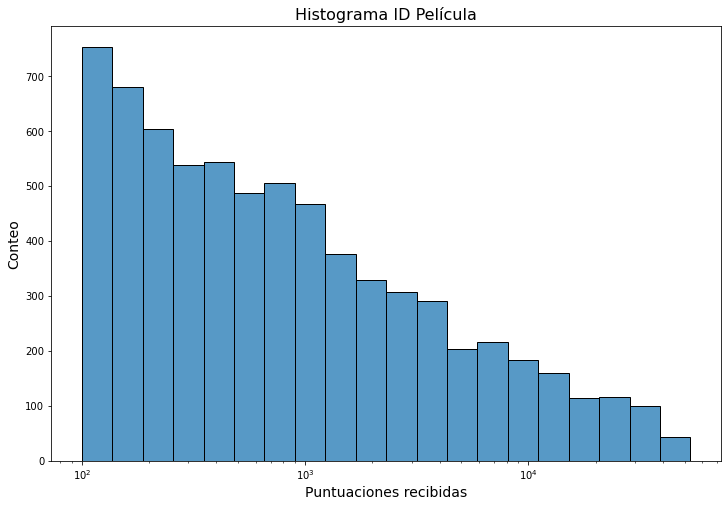

In [139]:
plt.figure(figsize=(12, 8))
sns.histplot(df_movie_filt,log_scale=True,bins=20)
plt.title('Histograma ID Película', fontsize=16)
# Configurar título y etiquetas
plt.xlabel('Puntuaciones recibidas', fontsize=14)
plt.ylabel('Conteo', fontsize=14)

In [129]:
df_user_filt = df_filt.groupby('user_id')['movie_id'].count()
df_user_filt.nsmallest(10)

user_id
1353     100
8493     100
12247    100
12353    100
13445    100
24033    100
25813    100
31743    100
38712    100
41726    100
Name: movie_id, dtype: int64

Text(0, 0.5, 'Conteo')

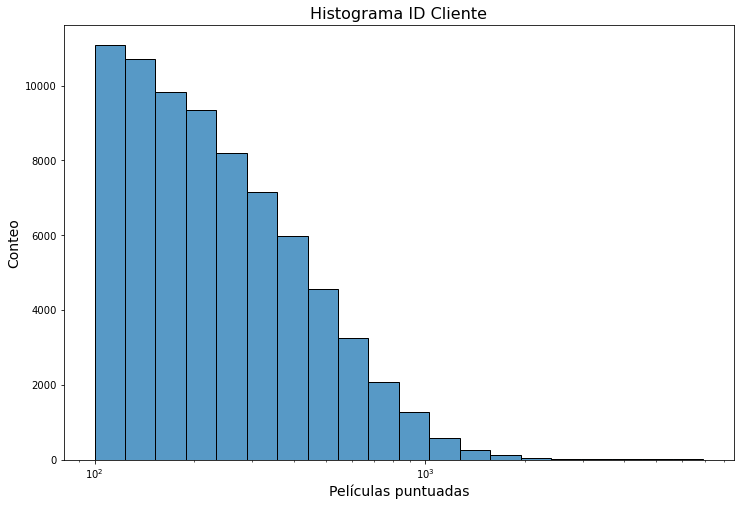

In [140]:
plt.figure(figsize=(12, 8))
sns.histplot(df_user_filt,log_scale=True,bins=20)
plt.title('Histograma ID Cliente', fontsize=16)
# Configurar título y etiquetas
plt.xlabel('Películas puntuadas', fontsize=14)
plt.ylabel('Conteo', fontsize=14)

# Guardamos el nuevo conjunto de datos

In [141]:
df_filt.to_parquet(f'../data/df_filt_{min_rates_movies}_{min_rates_users}.zip',compression='gzip')

In [143]:
%%time
df_trainval, df_test = train_test_split(df_filt,train_size=0.7,random_state=seed)
df_train, df_val = train_test_split(df_trainval,train_size=0.4/0.7,random_state=seed)

for _df,_df_str in zip([df_train, df_val, df_test],["df_train", "df_val", "df_test"]):
    print(f"{_df_str}: {_df.shape[0]}")

df_train: 8556951
df_val: 6417714
df_test: 6417714
Wall time: 6 s


In [155]:
print("COMPROBACION USUARIOS Y PELICULAS")
for _df,_df_str in zip([df_filt,df_train, df_val, df_test],["df_filt","df_train", "df_val", "df_test"]):
    print(f"{_df_str} tamaño: {_df.shape[0]}")

print()

for _df,_df_str in zip([df_filt,df_train, df_val, df_test],["df_filt","df_train", "df_val", "df_test"]):
    print(f"{_df_str} movies: {_df['movie_id'].drop_duplicates().shape[0]}")

print()

for _df,_df_str in zip([df_filt,df_train, df_val, df_test],["df_filt","df_train", "df_val", "df_test"]):
    print(f"{_df_str} users: {_df['user_id'].drop_duplicates().shape[0]}")

COMPROBACION USUARIOS Y PELICULAS
df_filt movies: 21392379
df_train movies: 8556951
df_val movies: 6417714
df_test movies: 6417714

df_filt movies: 7027
df_train movies: 7027
df_val movies: 7027
df_test movies: 7027

df_filt users: 74452
df_train users: 74452
df_val users: 74452
df_test users: 74452


In [152]:
for _df,_df_str in zip([df_train, df_val, df_test],["df_train", "df_val", "df_test"]):
    _df.to_parquet(f"../data/df_filt_{_df_str[3:]}_{min_rates_movies}_{min_rates_users}.zip",compression='gzip')